# 特征提取与处理

上一章案例中的解释变量都是数值，比如匹萨的直径。而很多机器学习问题需要研究的对象可能是分类变量、文字甚至图像。本章，我们介绍提取这些变量特征的方法。这些技术是数据处理的前提——序列化，更是机器学习的基础，影响到本书的所有章节。

## 分类变量特征提取

许多机器学习问题都有分类的、标记的变量，不是连续的。例如，一个应用是用分类特征比如工作地点来预测工资水平。分类变量通常用"一位有效编码"（One-of-K or One-Hot Encoding，【译者注】一位有效编码，主要是采用位状态寄存器来对个状态进行编码，每个状态都有他独立的寄存器位，并且在任意时候只有一位有效），通过二进制数来表示每个解释变量的特征)。

例如，假设`city`变量有三个值：`New York`, `San Francisco`, `Chapel Hill`。一位有效编码方式就是用三位二进制数，每一位表示一个城市。

scikit-learn里有`DictVectorizer`类可以用来表示分类特征：

In [1]:
from sklearn.feature_extraction import DictVectorizer

onehot_encoder = DictVectorizer()
instances = [{'city': 'New York'},{'city': 'San Francisco'}, {'city': 'Chapel Hill'}]
print(onehot_encoder.fit_transform(instances).toarray())

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]


编码的位置并不是与上面城市一一对应的。第一个`city`编码`New York`是`[ 0.  1.  0.]`，用第二个元素为`1`表示。相比用单独的数值来表示分类，这种方法看起来很直观。`New York`, `San Francisco`, `Chapel Hill`可以表示成`1`，`2`，`3`。数值的大小没有实际意义，城市并没有自然数顺序。

## 文字特征提取

很多机器学习问题涉及自然语言处理（NLP），必然要处理文字信息。文字必须转换成可以量化的特征向量。下面我们就来介绍最常用的文字表示方法：词库模型（Bag-of-words model）。

### 词库表示法

词库模型是文字模型化的最常用方法。对于一个文档（document），忽略其词序和语法，句法，将其仅仅看做是一个词集合，或者说是词的一个组合，文档中每个词的出现都是独立的，不依赖于其他词是否出现，或者说当这篇文章的作者在任意一个位置选择一个词汇都不受前面句子的影响而独立选择的。词库模型可以看成是一位有效编码的一种扩展，它为每个单词设值一个特征值。词库模型的依据是拥用类似单词的文章那么文章的意思也差不多。词库模型可以通过有限的编码信息实现有效的文档分类和检索。

一批文档的集合称为文集（corpus）。让我们用一个由两个文档组成的文集来演示词库模型：

In [2]:
corpus = [
    'UNC played Duke in basketball',
    'Duke lost the basketball game'
]

文集包括8个词：`UNC`, `played`, `Duke`, `in`, `basketball`, `lost`, `the`, `game`。文件的单词构成词汇表（vocabulary）。词库模型用文集的词汇表中每个单词的特征向量表示每个文档。我们的文集有8个单词，那么每个文档就是由一个包含8位元素的向量构成。构成特征向量的元素数量称为维度（dimension）。用一个词典（dictionary）来表示词汇表与特征向量索引的对应关系。

在大多数词库模型中，特征向量的每一个元素是用二进制数表示单词是否在文档中。例如，第一个文档的第一个词是`UNC`，词汇表的第一个单词是`UNC`，因此特征向量的第一个元素就是`1`。词汇表的最后一个单词是`game`。第一个文档没有这个词，那么特征向量的最后一个元素就是`0`。`CountVectorizer`类会把文档全部转换成小写，然后将文档词块化（tokenize）。文档词块化是把句子分割成词块（token）或有意义的字母序列的过程。词块大多是单词，但是他们也可能是一些短语，如标点符号和词缀。`CountVectorizer`类通过正则表达式用空格分割句子，然后抽取长度大于等于2的字母序列。scikit-learn实现代码如下：

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    'UNC played Duke in basketball',
    'Duke lost the basketball game'
]
vectorizer = CountVectorizer()
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[1 1 0 1 0 1 0 1]
 [1 1 1 0 1 0 1 0]]
{'unc': 7, 'played': 5, 'duke': 1, 'in': 3, 'basketball': 0, 'lost': 4, 'the': 6, 'game': 2}


让我们再增加一个文档到文集里：

In [4]:
corpus = [
    'UNC played Duke in basketball',
    'Duke lost the basketball game',
    'I ate a sandwich'
]
vectorizer = CountVectorizer()
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[0 1 1 0 1 0 1 0 0 1]
 [0 1 1 1 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 1 0 0]]
{'unc': 9, 'played': 6, 'duke': 2, 'in': 4, 'basketball': 1, 'lost': 5, 'the': 8, 'game': 3, 'ate': 0, 'sandwich': 7}


通过`CountVectorizer`类可以得出上面的结果。词汇表里面有10个单词，但`a`不在词汇表里面，是因为`a`的长度不符合`CountVectorizer`类的要求。

对比文档的特征向量，会发现前两个文档相比第三个文档更相似。如果用欧氏距离（Euclidean distance）计算它们的特征向量会比其与第三个文档距离更接近。两向量的欧氏距离就是两个向量欧氏范数（Euclidean norm）或L2范数差的绝对值：

$$
d = \begin{Vmatrix}
x_0 - x_1 \\
\end{Vmatrix}
$$

向量的欧氏范数是其元素平方和的平方根：

$$
\begin{Vmatrix}
x \\
\end{Vmatrix}
=\sqrt{x_1^2 + x_2^2 + \cdots + x_n^2}
$$

scikit-learn里面的`euclidean_distances`函数可以计算若干向量的距离，表示两个语义最相似的文档其向量在空间中也是最接近的。

In [5]:
from sklearn.metrics.pairwise import euclidean_distances

counts = vectorizer.fit_transform(corpus).todense()
for x,y in [[0,1],[0,2],[1,2]]:
    dist = euclidean_distances(counts[x],counts[y])
    print('文档{}与文档{}的距离{}'.format(x,y,dist))

文档0与文档1的距离[[ 2.44948974]]
文档0与文档2的距离[[ 2.64575131]]
文档1与文档2的距离[[ 2.64575131]]


如果我们用新闻报道内容做文集，词汇表就可以用成千上万个单词。每篇新闻的特征向量都会有成千上万个元素，很多元素都会是0。体育新闻不会包含财经新闻的术语，同样文化新闻也不会包含财经新闻的术语。有许多零元素的高维特征向量成为稀疏向量（sparse vectors）。

对任何机器学习任务使用高维数据都会有一些问题，不只是出现在自然语言处理领域。第一个问题就是高维向量需要占用更大内存。NumPy提供了一些数据类型只显示稀疏向量的非零元素，可以有效处理这个问题。

第二个问题就是著名的维度灾难（curse of dimensionality，Hughes effect），维度越多就要求更大的训练集数据保证模型能够充分学习。如果训练样本不够，那么算法就可能拟合过度导致归纳失败。下面，我们介绍一些降维的方法。在第7章，PCA降维里面，我们还会介绍用数值方法降维。

### 停用词过滤

特征向量降维的一个基本方法是单词全部转换成小写。这是因为单词的大小写一般不会影响意思。而首字母大写的单词一般只是在句子的开头，而词库模型并不在乎单词的位置和语法。

另一种方法是去掉文集常用词。这些词称为停用词（stop-word），像`a`，`an`，`the`，助动词`do`，`be`，`will`，介词`on`，`around`，`beneath`等。停用词通常是通过语法构建文档意思的功能词汇，其字面意义并不体现。`CountVectorizer`类可以通过设置`stop_words`参数过滤停用词，默认是英语常用的停用词。

In [6]:
corpus = [
    'UNC played Duke in basketball',
    'Duke lost the basketball game',
    'I ate a sandwich'
]
vectorizer = CountVectorizer(stop_words='english')
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[0 1 1 0 0 1 0 1]
 [0 1 1 1 1 0 0 0]
 [1 0 0 0 0 0 1 0]]
{'unc': 7, 'played': 5, 'duke': 2, 'basketball': 1, 'lost': 4, 'game': 3, 'ate': 0, 'sandwich': 6}


这样停用词就没有了，前两篇文档依然相比其与第三篇的内容更接近。

### 词根还原与词形还原

停用词去掉之后，可能还会剩下许多词，还有一种常用的方法就是词根还原（stemming ）与词形还原（lemmatization）。

特征向量里面的单词很多都是一个词的不同形式，比如`jumping`和`jumps`都是`jump`的不同形式。词根还原与词形还原就是为了将单词从不同的时态、派生形式还原。

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    'He ate the sandwiches',
    'Every sandwich was eaten by him'
]
vectorizer = CountVectorizer(binary=True, stop_words='english')
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[1 0 0 1]
 [0 1 1 0]]
{'ate': 0, 'sandwiches': 3, 'sandwich': 2, 'eaten': 1}


这两个文档意思差不多，但是其特征向量完全不同，因为单词的形式不同。两个单词都是有一个动词`eat`和一个`sandwich`，这些特征应该在向量中反映出来。词形还原就是用来处理可以表现单词意思的词元（lemma）或形态学的词根（morphological root）的过程。词元是单词在词典中查询该词的基本形式。词根还原与词形还原类似，但它不是生成单词的形态学的词根。而是把附加的词缀都去掉，构成一个词块，可能不是一个正常的单词。词形还原通常需要词法资料的支持，比如WordNet和单词词类（part of speech）。词根还原算法通常需要用规则产生词干（stem）并操作词块，不需要词法资源，也不在乎单词的意思。

让我们分析一下单词`gathering`的词形还原：

In [9]:
corpus = [
    'I am gathering ingredients for the sandwich.',
    'There were many wizards at the gathering.'
]

第一句的`gathering`是动词，其词元是`gather`。后一句的`gathering`是名词，其词元是`gathering`。我们用Python的[NLTK（Natural
Language Tool Kit）](http://www.nltk.org/install.html)库来处理。

In [11]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


SystemExit: 0

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


NLTK的`WordNetLemmatizer`可以用`gathering`的词类确定词元。

In [3]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('gathering', 'v'))
print(lemmatizer.lemmatize('gathering', 'n'))

gather
gathering


我们把词形还原应用到之前的例子里：

In [6]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
wordnet_tags = ['n', 'v']
corpus = [
    'He ate the sandwiches',
    'Every sandwich was eaten by him'
]

stemmer = PorterStemmer()
print('Stemmed:', [[stemmer.stem(token) for token in word_tokenize(document)] for document in corpus])

Stemmed: [['He', 'ate', 'the', 'sandwich'], ['Everi', 'sandwich', 'wa', 'eaten', 'by', 'him']]


In [9]:
def lemmatize(token, tag):
    if tag[0].lower() in ['n', 'v']:
        return lemmatizer.lemmatize(token, tag[0].lower())
    return token

lemmatizer = WordNetLemmatizer()
tagged_corpus = [pos_tag(word_tokenize(document)) for document in corpus]
print('Lemmatized:', [[lemmatize(token, tag) for token, tag in document] for document in tagged_corpus])

Lemmatized: [['He', 'eat', 'the', 'sandwich'], ['Every', 'sandwich', 'be', 'eat', 'by', 'him']]


通过词根还原与词形还原可以有效降维，去掉不必要的单词形式，特征向量可以更有效的表示文档的意思。

### 带TF-IDF权重的扩展词库

前面我们用词库模型构建了判断一个单词是否在文档中出现的特征向量。这些特征向量与单词的语法，顺序，频率无关。不过直觉告诉我们文档中单词的频率对文档的意思有重要作用。一个文档中某个词多次出现，相比只出现过一次的单词更能体现反映文档的意思。现在我们就将单词频率加入特征向量，然后介绍由词频引出的两个问题。

我们用一个整数来代码单词的频率。代码如下：

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['The dog ate a sandwich, the wizard transfigured a sandwich, and I ate a sandwich']
vectorizer = CountVectorizer(stop_words='english')
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[2 1 3 1 1]]
{'dog': 1, 'ate': 0, 'sandwich': 2, 'wizard': 4, 'transfigured': 3}


结果中第一行是单词的频率，`dog`频率为`1`，`sandwich`频率为`3`。注意和前面不同的是，`binary=True`没有了，因为`binary`默认是`False`，这样返回的是词汇表的词频，不是二进制结果`[1 1 1 1 1]`。这种单词频率构成的特征向量为文档的意思提供了更多的信息，但是在对比不同的文档时，需要考虑文档的长度。

很多单词可能在两个文档的频率一样，但是两个文档的长度差别很大，一个文档比另一个文档长很多倍。scikit-learn的`TfdfTransformer`类可以解决这个问题，通过对词频（term frequency）特征向量归一化来实现不同文档向量的可比性。默认情况下，`TfdfTransformer`类用L2范数对特征向量归一化：

$$tf(t,d)= \frac {f(t,d)+1} {\begin{Vmatrix}x\end{Vmatrix}}$$

$f(t,d)$是第$d$个文档（document）第$t$个单词（term）的频率，$\begin{Vmatrix}x\end{Vmatrix}$是频率向量的L2范数。另外，还有对数词频调整方法（logarithmically scaled term frequencies），把词频调整到一个更小的范围，或者词频放大法（augmented term frequencies），适用于消除较长文档的差异。对数词频公式如下：

$$tf(t,d)= log(f(t,d)+1)$$

`TfdfTransformer`类计算对数词频调整时，需要将参数`sublinear_tf`设置为`True`。词频放大公式如下：

$$tf(t,d)= 0.5 + \frac {f(t,d)+1} {max f(w,d): w \in d}$$

$max f(w,d): w \in d$是文档$d$中的最大词频。scikit-learn没有现成可用的词频放大公式，不过通过`CountVectorizer`可以轻松实现。

归一化，对数调整词频和词频放大三个方法都能消除文档不同大小对词频的影响。但是，另一个问题仍然存在，那就是特征向量里高频词的权重更大，即使这些词在文集内其他文档里面也经常出现。这些单词并没有突出代表单个文档的意思。比如，一个文集里大多数文档都是关于杜克大学篮球队的，那么高频词就是`basketball`，`Coach K`，`flop`。这些词可以被看成是该文集的停用词，因为它们太普遍对区分文档的意思没任何作用。逆向文件频率（inverse document frequency，IDF）就是用来度量文集中单词频率的。

$$idf(t,D)= log(\frac N {1+|d \in D:t \in d|})$$

其中，$N$是文集中文档数量，$d \in D:t \in d$表示包含单词$t$的文档数量。单词的TF-IDF值就是其频率与逆向文件频率的乘积。

`TfdfTransformer`类默认返回TF-IDF值，其参数`use_idf`默认为`True`。由于TF-IDF加权特征向量经常用来表示文本，所以scikit-learn提供了`TfidfVectorizer`类将`CountVectorizer`和`TfdfTransformer`类封装在一起。

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'The dog ate a sandwich and I ate a sandwich',
    'The wizard transfigured a sandwich'
]
vectorizer = TfidfVectorizer(stop_words='english')
print(vectorizer.fit_transform(corpus).todense())
print(vectorizer.vocabulary_)

[[ 0.75458397  0.37729199  0.53689271  0.          0.        ]
 [ 0.          0.          0.44943642  0.6316672   0.6316672 ]]
{'dog': 1, 'ate': 0, 'sandwich': 2, 'wizard': 4, 'transfigured': 3}


通过TF-IDF加权之后，我们会发现在文集中较常见的词，如`sandwich`被调整了。

### 通过哈希技巧实现特征向量

前面我们是用包含文集所有词块的词典来完成文档词块与特征向量的映射的。这么做有两个缺点。首先是文集需要被调用两次。第一次是创建词典，第二次是创建文档的特征向量。另外，词典必须储存在内存里，如果文集特别大就会很耗内存。通过哈希表可以有效的解决这些问题。可以将词块用哈希函数来确定它在特征向量的索引位置，可以不创建词典，这称为哈希技巧（hashing trick）。scikit-learn提供了`HashingVectorizer`来实现这个技巧：

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer

corpus = ['the', 'ate', 'bacon', 'cat']
vectorizer = HashingVectorizer(n_features=6)
print(vectorizer.transform(corpus).todense())

[[-1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0.  0.]]


哈希技巧是无固定状态的（stateless），它把任意的数据块映射到固定数目的位置，并且保证相同的输入一定产生相同的输出，不同的输入尽可能产生不同的输出。它可以用并行，线上，流式传输创建特征向量，因为它初始化是不需要文集输入。`n_features`是一个可选参数，默认值是$2^{20}$，这里设置成`6`是为了演示。另外，注意有些单词频率是负数。由于Hash碰撞可能发生，所以`HashingVectorizer`用有符号哈希函数（signed hash function）。特征值和它的词块的哈希值带同样符号，如果`cats`出现过两次，被哈希成`-3`，文档特征向量的第四个元素要减去`2`。如果`dogs`出现过两次，被哈希成`3`，文档特征向量的第四个元素要加上`2`。

用带符号哈希函数可以把词块发生哈希碰撞的概率相互抵消掉，信息损失比信息损失的同时出现信息冗余要好。哈希技巧的一个不足是模型的结果更难察看，由于哈希函数不能显示哪个词块映射到特征向量的哪个位置了。

## 图片特征提取

计算机视觉是一门研究如何使机器“看”的科学，让计算机学会处理和理解图像。这门学问有时需要借助机器学习。本章介绍一些机器学习在计算机视觉领域应用的基础技术。

### 通过像素值提取特征

数字图像通常是一张光栅图或像素图，将颜色映射到网格坐标里。一张图片可以看成是一个每个元素都是颜色值的矩阵。表示图像基本特征就是将矩阵每行连起来变成一个行向量。光学文字识别（Optical character recognition，OCR）是机器学习的经典问题。下面我们用这个技术来识别手写数字。

scikit-learn的`digits`数字集包括至少1700种0-9的手写数字图像。每个图像都有8x8像像素构成。每个像素的值是0-16，白色是0，黑色是16。如下图所示：

Digit: 0
[[  0.   0.   5.  13.   9.   1.   0.   0.]
 [  0.   0.  13.  15.  10.  15.   5.   0.]
 [  0.   3.  15.   2.   0.  11.   8.   0.]
 [  0.   4.  12.   0.   0.   8.   8.   0.]
 [  0.   5.   8.   0.   0.   9.   8.   0.]
 [  0.   4.  11.   0.   1.  12.   7.   0.]
 [  0.   2.  14.   5.  10.  12.   0.   0.]
 [  0.   0.   6.  13.  10.   0.   0.   0.]]


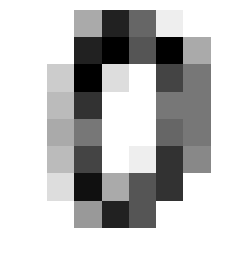

In [15]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print('Digit:', digits.target[0])
print(digits.images[0])
plt.figure()
plt.axis('off')
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

我们将8x8矩阵转换成64维向量来创建一个特征向量：

In [32]:
digits = datasets.load_digits()
print('Feature vector:\n', digits.images[0].reshape(-1, 64))

Feature vector:
 [[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]]


这样表示可以有效的处理一些基本任务，比如识别手写字母等。但是，记录每个像素的数值在大图像处理时不太好用。一个100x100像素的图像其灰度图产生的特征向量是10000维度，而1920x1080像素的图像是2073600。和TF-IDF特征向量不同，大部分图像都不是稀疏的。这种表示法的缺点不只是特征向量的维度灾难，还有就是某个位置的学习结果在经过对图像的放缩，旋转或变换之后可能就不对了，非常敏感，缺乏稳定性。另外，这种方法对图像的亮度也十分敏感。所以这种方法在处理照片和其他自然景色图像时不怎么有用。现代计算机视觉应用通常手工实现特征提取，或者用深度学习自动化解决无监督问题。后面我们会详细介绍。

### 对感兴趣的点进行特征提取

前面创建的特征矢量包含了图像的每个像素，既包含了图像特征的有用信息，也包含了一堆噪声。查看图像后，我们会发现所有的图像都有一个白边，这些像素是没用的。人们不需要观察物体的每个属性就可以很快的识别出很多物体。我们可以根据轮廓识别出汽车，并不需要观察后视镜，我们也可以通过一个鼻子或嘴巴判断图像是一个人。这些直觉就可以用来建立一种表示图像大多数信息属性的方法。这些有信息量的属性，称为兴趣点（points of interest），是由丰富的纹理包围，基本可以重建图像。边缘（edges）和角点（corners）是两种常用的兴趣点类型。边是像素快速变化的分界线（boundary），角是两条边的交集。我们用scikit-image库抽取下图的兴趣点：

![mandrill](mlslpic/3.1 mandrill.png)

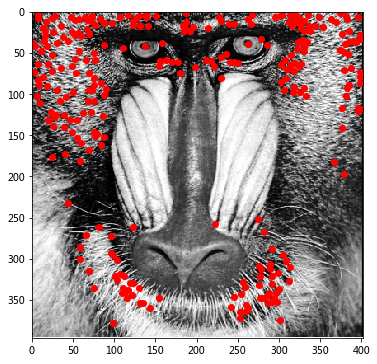

In [16]:
%matplotlib inline
import numpy as np
from skimage.feature import corner_harris, corner_peaks
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.exposure import equalize_hist


def show_corners(corners, image):
    fig = plt.figure()
    plt.gray()
    plt.imshow(image)
    y_corner, x_corner = zip(*corners)
    plt.plot(x_corner, y_corner, 'or')
    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
    plt.show()

mandrill = io.imread('mlslpic/3.1 mandrill.png')
mandrill = equalize_hist(rgb2gray(mandrill))
corners = corner_peaks(corner_harris(mandrill), min_distance=2)
show_corners(corners, mandrill)

上图就是兴趣点的提取结果。图片的230400个像素中，466个兴趣点被提取。这种提取方式更紧凑，而且当图片的亮度发生统一变化时，这些兴趣点依然存在。

### SIFT和SURF

尺度不变特征转换（Scale-Invariant Feature Transform，SIFT）是一种特征提取方法，相比前面使用的方法，SIFT对图像的尺寸，旋转，亮度变化更不敏感。每个SIFT特征都是一个描述图片上某个区域边缘和角点的向量。和兴趣点不同，SIFT还可以获取每个兴趣点和它周围点的综合信息。加速稳健特征（Speeded-Up Robust Features，SURF）是另一个抽取图像兴趣点的方法，其特征向量对图像的尺寸，旋转，亮度变化是不变的。SURF的算法可以比SIFT更快，更有效的识别出兴趣点。

两种方法的具体理论解释在数字图像处理类的教材中都有介绍，感兴趣的同学可以研究。这样用`mahotas`库来应用SURF方法处理下面的图片。

![xiaobao](mlslpic/3.2 xiaobao.png)

和兴趣点抽取类似，抽取SURF只是机器学习中创建特征向量的第一步。训练集的每个实例都会抽取不同的SURF。第六章的，K-Means聚类，我们会介绍聚类方法抽取SURF来学习特征，可以作为一种图像分类方法。`mahotas`代码如下：

In [3]:
import mahotas as mh
from mahotas.features import surf

image = mh.imread('mlslpic/3.2 xiaobao.png', as_grey=True)
print('第一个SURF描述符：\n{}\n'.format(surf.surf(image)[0]))
print('抽取了%s个SURF描述符' % len(surf.surf(image)))

第一个SURF描述符：
[  1.15299134e+02   2.56185453e+02   3.51230841e+00   3.32786485e+02
   1.00000000e+00   1.75644866e+00  -2.94268692e-03   3.30736379e-03
   2.94268692e-03   3.30736379e-03  -2.58778609e-02   3.25587066e-02
   2.58778609e-02   3.25587066e-02  -3.03768176e-02   4.18212640e-02
   3.03768176e-02   4.18212640e-02  -5.75169209e-03   7.66422266e-03
   5.75169209e-03   7.66422266e-03  -1.85200481e-02   3.10523761e-02
   1.85200481e-02   3.10523761e-02  -9.61023554e-02   2.59842816e-01
   1.12794174e-01   2.59842816e-01  -6.66368114e-02   2.72006376e-01
   1.40583321e-01   2.72006376e-01  -1.91014197e-02   5.28250599e-02
   2.03376276e-02   5.28250599e-02  -2.24247135e-02   3.35105185e-02
   2.24247135e-02   3.35105185e-02  -2.36547964e-01   3.18867366e-01
   2.36547964e-01   3.18867366e-01  -2.49737941e-01   3.00644512e-01
   2.50125503e-01   3.03596724e-01  -1.69936886e-02   3.82398567e-02
   2.00617910e-02   3.82398567e-02  -3.72417955e-03   5.53246035e-03
   3.72417955e-03   5.

## 数据标准化

许多评估方法在处理标准化数据集时可以获得更好的效果。标准化后的数据均值为`0`并拥有单位方差(Unit Variance)。均值为`0`的解释变量是关于原点对称的，特征向量的单位方差表示其特征值全身统一单位，统一量级的数据。例如，假设特征向量由两个解释变量构成，第一个变量值范围`[0,1]`，第二个变量值范围`[0,1000000]`，这时就要把第二个变量的值调整为`[0,1]`，这样才能保证数据是单位方差。如果变量特征值的量级比其他特征值的方差还大，这个特征值就会主导学习算法的方向，导致其他变量的影响被忽略。有些机器学习算法会在数据不标准时引入很小的优化参数值。解释变量的值可以通过正态分布进行标准化，减去均值后除以标准差。scikit-learn的`scale`函数可以实现：

In [17]:
from sklearn import preprocessing
import numpy as np
X = np.array([
    [0., 0., 5., 13., 9., 1.],
    [0., 0., 13., 15., 10., 15.],
    [0., 3., 15., 2., 0., 11.]
])
print(preprocessing.scale(X))

[[ 0.         -0.70710678 -1.38873015  0.52489066  0.59299945 -1.35873244]
 [ 0.         -0.70710678  0.46291005  0.87481777  0.81537425  1.01904933]
 [ 0.          1.41421356  0.9258201  -1.39970842 -1.4083737   0.33968311]]


## 总结

本章我们介绍了特征提取的方法的基础知识，将不同类型的数据转换成特征向量方便机器学习算法研究。首先，我们介绍了分类数据的一位有效编码方法，并用scikit-learn的`DictVectorizer`类实现。然后，介绍了许多机器学习问题中常见的文档特征向量。通过词库模型将文档转换成词块的频率构成的特征向量，用`CountVectorizer`类计算基本单词频次的二进制特征向量。最后，通过停用词过滤，词根还原，词形还原进一步优化特征向量，并加入TF-IDF权重调整文集常见词，消除文档长度对特征向量的影响。

之后，我们介绍了图像特征提取的方法。首先，我们介绍了一个关于的手写数字识别的OCR问题，通过图像的像素矩阵扁平化来学习手写数字特征。这种方法非常耗费资源，于是我们引入兴趣点提取方法，通过SIFT和SURF进行优化。

最后介绍了数据标准化的方法，确保解释变量的数据都是同一量级，均值为`0`的标准化数据。特征提取技术在后面的章节中会不断使用。下一章，我们把词库模型和多元线性回归方法结合来实现文档分类。

> 感谢: 中文原文出处，[绿萝间](https://muxuezi.github.io)  

> 英文原版书: [Mastering Machine Learning with scikit-learn, Packet 2014](https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781783988365)